In [2]:
import logging
logging.root.handlers = []  # Jupyter messes up logging so needs a reset
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
from smart_open import smart_open
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
from sklearn.cross_validation import train_test_split
from sklearn import linear_model
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model
from nltk.corpus import stopwords
import os, codecs
%matplotlib inline
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords

2017-02-12 23:55:47,632 : INFO : 'pattern' package found; tag filters are available for English
/usr/lib64/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
class MySentences(object):
    def __init__(self, dirname):
        self.dirname = dirname
 
    def __iter__(self):
        for fname in os.listdir(self.dirname):
            for line in codecs.open(os.path.join(self.dirname, fname)) :
                yield line.split()

In [4]:
sentences = MySentences('/home/bahbbc/Documents/b5-post(confidencial)/lemmatised') # a memory-friendly iterator

In [5]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
num_features = 300
min_word_count = 1   # Minimum word count                        
num_workers = 40       # Number of threads to run in parallel
context = 10          # Context window size             



model = gensim.models.Word2Vec(sentences, workers=num_workers, \
            size=num_features, min_count = min_word_count, window = context)

2017-02-12 23:55:51,864 : INFO : collecting all words and their counts
2017-02-12 23:55:51,870 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2017-02-12 23:55:51,951 : INFO : PROGRESS: at sentence #10000, processed 140779 words, keeping 6006 word types
2017-02-12 23:55:52,013 : INFO : PROGRESS: at sentence #20000, processed 280423 words, keeping 8776 word types
2017-02-12 23:55:52,071 : INFO : PROGRESS: at sentence #30000, processed 417581 words, keeping 10562 word types
2017-02-12 23:55:52,128 : INFO : PROGRESS: at sentence #40000, processed 561528 words, keeping 12004 word types
2017-02-12 23:55:52,186 : INFO : PROGRESS: at sentence #50000, processed 713051 words, keeping 13185 word types
2017-02-12 23:55:52,240 : INFO : PROGRESS: at sentence #60000, processed 853336 words, keeping 14259 word types
2017-02-12 23:55:52,297 : INFO : PROGRESS: at sentence #70000, processed 993522 words, keeping 15132 word types
2017-02-12 23:55:52,355 : INFO : PROGRESS: at se

In [6]:
model.save('/home/bahbbc/Documents/personality_lema')

2017-02-12 23:56:07,541 : INFO : saving Word2Vec object under /home/bahbbc/Documents/personality_lema, separately None
2017-02-12 23:56:07,542 : INFO : not storing attribute syn0norm
2017-02-12 23:56:07,543 : INFO : not storing attribute cum_table
2017-02-12 23:56:07,809 : INFO : saved /home/bahbbc/Documents/personality_lema


In [66]:
model = gensim.models.Word2Vec.load('/home/bahbbc/Documents/personality_lema')
#model = Word2Vec.load_word2vec_format('/home/bahbbc/Documents/teste-personalidade/personality_1',binary=True)
model.init_sims(replace=True)

2017-02-13 08:29:50,580 : INFO : loading Word2Vec object from /home/bahbbc/Documents/personality_lema
2017-02-13 08:29:50,857 : INFO : loading wv recursively from /home/bahbbc/Documents/personality_lema.wv.* with mmap=None
2017-02-13 08:29:50,858 : INFO : setting ignored attribute syn0norm to None
2017-02-13 08:29:50,859 : INFO : setting ignored attribute cum_table to None
2017-02-13 08:29:50,860 : INFO : loaded /home/bahbbc/Documents/personality_lema
2017-02-13 08:29:50,930 : INFO : precomputing L2-norms of word weight vectors


In [67]:
print(model.most_similar(positive=['gato', 'cachorro']))

[('gatar', 0.8446024060249329), ('urso', 0.7607353925704956), ('filhote', 0.7597928643226624), ('cabelo', 0.7519885301589966), ('morder', 0.7453254461288452), ('beb\xea', 0.7379262447357178), ('sorvete', 0.7368520498275757), ('fofo', 0.7362188100814819), ('batom', 0.7316741347312927), ('loirar', 0.7311310768127441)]


### Verify model with personality

In [68]:
df = pd.read_csv('~/personality-normalized-word2vec-lema.csv', encoding='utf_8')
df = df.dropna()

In [69]:
df.extraversion_m.value_counts()

0    242
1    214
Name: extraversion_m, dtype: int64

In [70]:
train_data, test_data = train_test_split(df, test_size=0.3, random_state=42)

### Evaluation code

In [71]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    target_names = ['no', 'yes']
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [72]:
def evaluate_prediction(predictions, target, title="Confusion matrix"):
    print('accuracy %s' % accuracy_score(target, predictions))
    cm = confusion_matrix(target, predictions)
    print('confusion matrix\n %s' % cm)
    print('(row=expected, col=predicted)')
    
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plot_confusion_matrix(cm_normalized, title + ' Normalized')

In [73]:
def predict(vectorizer, classifier, data):
    data_features = vectorizer.transform(data['formatted_text'])
    predictions = classifier.predict(data_features)
    target = data['extraversion_m']
    evaluate_prediction(predictions, target)

In [74]:
test_data['formatted_text']

819    ser um grande ano ! obrigar por fazer partir d...
75           $FOREIGN$ $FOREIGN$ ' sim $FOREIGN$ mora...
778    tranquilos . . . .  o ano só estar começar . ....
434      oi gente ! ! !  então , saber aquelar promoç...
303      existir crise em muito quintar . . . existir...
399    igual suar mãe $NAME$ pinheiro  sensacional ! ...
350          $FOREIGN$ $FOREIGN$ $FOREIGN$ $FOREIGN$ ...
148    ruim de chutar    $NAME$ o resultar do análise...
862      quem dar que a pessoa que amar ser eternar ....
63     programar ! concentração ! ! $LAUGH$  $NAME$ $...
111    $EMOTION*$ ! ir safar  despedir  e que ninguém...
340    idéia o dançar livrar . . . . $NAME$ $NAME$ $N...
257    fazer gordices  $NAME$ $NAME$ '  olhar que leg...
794    cunhãs amar casamentar $NAME$ $NAME$  amor meu...
826    $NAME$ $NAME$ eu pedir parir ter delicadeza co...
91       show estranhar , com gente esquisito !    ge...
695    $NAME$ $NAME$ $NAME$ e $NAME$ $NAME$        $F...
659    um dia ele exército  chu

### Word2Vec model training

In [75]:
def word_averaging(wv, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.wv.vocab:
            mean.append(wv.wv.syn0norm[wv.wv.vocab[word].index])
            all_words.add(wv.wv.vocab[word].index)

    if not mean:
        logging.warning("cannot compute similarity with no input %s", words)
        # FIXME: remove these examples in pre-processing
        return np.zeros(num_features,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, review) for review in text_list ])

In [76]:

def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens

In [77]:
test_tokenized = test_data.apply(lambda r: w2v_tokenize_text(r['formatted_text']), axis=1).values
train_tokenized = train_data.apply(lambda r: w2v_tokenize_text(r['formatted_text']), axis=1).values

In [78]:
%%time
X_train_word_average = word_averaging_list(model,train_tokenized)
X_test_word_average = word_averaging_list(model,test_tokenized)

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:7: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal


CPU times: user 1.81 s, sys: 2.12 ms, total: 1.81 s
Wall time: 1.81 s


In [79]:
%%time
logreg = linear_model.LogisticRegression(n_jobs=1, C=1e5)

logreg = logreg.fit(X_train_word_average, train_data['extraversion_m'])
predicted = logreg.predict(X_test_word_average)

CPU times: user 306 ms, sys: 987 µs, total: 307 ms
Wall time: 307 ms


accuracy 0.540145985401
confusion matrix
 [[34 35]
 [28 40]]
(row=expected, col=predicted)


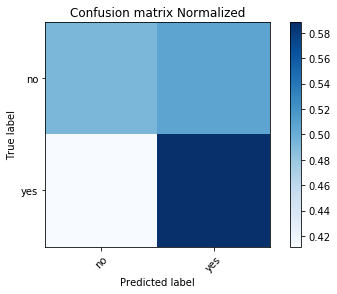

In [80]:
evaluate_prediction(predicted, test_data.extraversion_m)

## Remove stop words

In [81]:

def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='portuguese'):
        for word in nltk.word_tokenize(sent, language='portuguese'):
            if len(word) < 2:
                continue
            if word in stopwords.words('portuguese'):
                continue
            tokens.append(word)
    return tokens

In [82]:
test_tokenized = test_data.apply(lambda r: w2v_tokenize_text(r['formatted_text']), axis=1).values
train_tokenized = train_data.apply(lambda r: w2v_tokenize_text(r['formatted_text']), axis=1).values

In [83]:
%%time
X_train_word_average = word_averaging_list(model,train_tokenized)
X_test_word_average = word_averaging_list(model,test_tokenized)

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:7: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
2017-02-13 08:33:03,269 : WARNING : cannot compute similarity with no input [u'FOREIGN', u'NAME', u'NAME', u'NAME', u'NAME', u'NAME']


CPU times: user 1.67 s, sys: 4.76 ms, total: 1.68 s
Wall time: 1.68 s


In [84]:
%%time
logreg = linear_model.LogisticRegression(n_jobs=1, C=1e5)

logreg = logreg.fit(X_train_word_average, train_data['extraversion_m'])
predicted = logreg.predict(X_test_word_average)

CPU times: user 460 ms, sys: 1.01 ms, total: 461 ms
Wall time: 465 ms


accuracy 0.503649635036
confusion matrix
 [[28 41]
 [27 41]]
(row=expected, col=predicted)


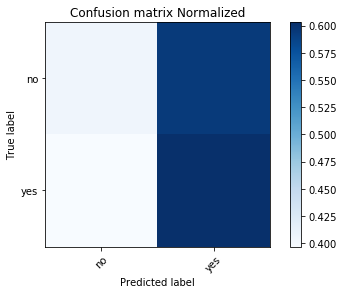

In [85]:
evaluate_prediction(predicted, test_data.extraversion_m)

## Doc2Vec

In [86]:
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

In [87]:

def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens

In [88]:
train_tagged = train_data.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['formatted_text']), tags=[r.extraversion_m]), axis=1)

In [89]:
test_tagged = test_data.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['formatted_text']), tags=[r.extraversion_m]), axis=1)

In [90]:
test_tagged.values[50]

TaggedDocument(words=[u'quando', u'bandido', u'n\xe3o', u'tocar', u'meu', u'cora\xe7\xe3o', u'ser', u'vermelhar', u'amarelar', u'ir', u'bandido', u'ir', u'torcer', u'partir', u'eu', u'voc\xea', u'dois', u'intruso', u'muito', u'amor', u'name', u'baby', u'panda', u'lindar', u'balatucada', u'acabar', u'amar', u'balatucada', u'partir', u'meu', u'amorar', u'eu', u'fam\xedlia', u'number', u'estar', u'chegar', u'ser', u's\xe1bado', u'a\xed', u'meu', u'cora\xe7\xe3o', u'amigo', u'foreign', u'name', u'saudade', u'partir', u'cantar', u'combinar', u'amar', u'emotion*', u'name', u'number', u'foreign', u'foreign', u'name', u'foreign', u'foreign', u'foreign', u'ser', u'lindar', u'maravilhoso', u'um', u'verdadeiro', u'diva', u'panda', u'do', u'panda', u'number', u'm\xeas', u'parir', u'melhor', u'rol\xea', u'do', u'ano', u'estar', u'chegar', u'bandido', u'dessar', u'vez', u'ir', u'dj', u'bruxar', u'mais', u'um', u'rol\xea', u'mais', u'panar', u'pro', u'mangar', u'number', u'acumular', u'carimbo', u'nu

In [91]:
%%time
trainsent = train_tagged.values
testsent = test_tagged.values

# simple gensim doc2vec api
doc2vec_model = Doc2Vec(trainsent, workers=1, size=5, iter=20, dm=1)

train_targets, train_regressors = zip(
    *[(doc.tags[0], doc2vec_model.infer_vector(doc.words, steps=20)) for doc in trainsent])

2017-02-13 08:33:31,401 : WARNING : consider setting layer size to a multiple of 4 for greater performance
2017-02-13 08:33:31,404 : INFO : collecting all words and their counts
2017-02-13 08:33:31,405 : INFO : PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
2017-02-13 08:33:31,696 : INFO : collected 14548 word types and 2 unique tags from a corpus of 319 examples and 621774 words
2017-02-13 08:33:31,697 : INFO : Loading a fresh vocabulary
2017-02-13 08:33:31,748 : INFO : min_count=5 retains 5164 unique words (35% of original 14548, drops 9384)
2017-02-13 08:33:31,750 : INFO : min_count=5 leaves 606014 word corpus (97% of original 621774, drops 15760)
2017-02-13 08:33:31,777 : INFO : deleting the raw counts dictionary of 14548 items
2017-02-13 08:33:31,778 : INFO : sample=0.001 downsamples 55 most-common words
2017-02-13 08:33:31,779 : INFO : downsampling leaves estimated 399608 word corpus (65.9% of prior 606014)
2017-02-13 08:33:31,780 : INFO : estimated requir

CPU times: user 23.1 s, sys: 106 ms, total: 23.2 s
Wall time: 23.3 s


In [92]:
%%time
test_targets, test_regressors = zip(
    *[(doc.tags[0], doc2vec_model.infer_vector(doc.words, steps=20)) for doc in testsent])

CPU times: user 5.68 s, sys: 0 ns, total: 5.68 s
Wall time: 5.75 s


accuracy 0.518248175182
confusion matrix
 [[46 23]
 [43 25]]
(row=expected, col=predicted)


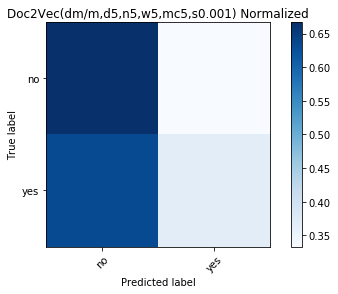

In [93]:
logreg = linear_model.LogisticRegression(n_jobs=1, C=1e5)
logreg = logreg.fit(train_regressors, train_targets)
evaluate_prediction(logreg.predict(test_regressors), test_targets, title=str(doc2vec_model))

2017-02-13 08:34:00,702 : INFO : precomputing L2-norms of doc weight vectors


accuracy 0.583941605839
confusion matrix
 [[37 32]
 [25 43]]
(row=expected, col=predicted)
CPU times: user 207 ms, sys: 90.7 ms, total: 298 ms
Wall time: 204 ms


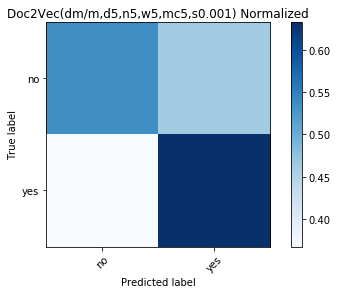

In [94]:
%%time 
knn_test_predictions = [
    doc2vec_model.docvecs.most_similar([pred_vec], topn=1)[0][0]
    for pred_vec in test_regressors
]
evaluate_prediction(knn_test_predictions, test_targets, str(doc2vec_model))

Fitting a random forest to labeled training data...
accuracy 0.583941605839
confusion matrix
 [[46 23]
 [34 34]]
(row=expected, col=predicted)


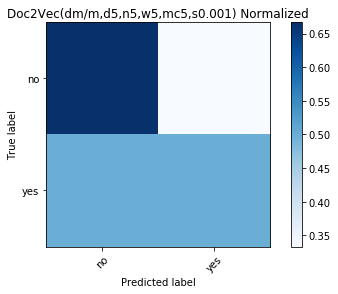

In [95]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier( n_estimators = 100 )

print "Fitting a random forest to labeled training data..."
forest = forest.fit( train_regressors, train_data["extraversion_m"] )

# Test & extract results 
result = forest.predict( test_regressors )

evaluate_prediction(result, test_targets, str(doc2vec_model))